In [98]:
!wget -nc http://ml_course.gordinmitya.ru/modified_public.zip
!unzip -o modified_public.zip

File ‘modified_public.zip’ already there; not retrieving.

Archive:  modified_public.zip
  inflating: modified_public/xt_modified.npy  
  inflating: modified_public/xs.npy  
  inflating: modified_public/ys.npy  


In [99]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense
import random as rn
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

In [100]:
X_train = np.load('modified_public/xs.npy')
y_train = np.load( 'modified_public/ys.npy')

In [101]:
X_train.shape

(52500, 32, 32, 3)

In [102]:
y_hot = tf.one_hot(y_train, 9)

In [103]:
y_hot.shape

TensorShape([52500, 9])

In [104]:
x_train, x_test, y_train, y_test = train_test_split(X_train, y_hot.numpy(), test_size = 0.4)

In [105]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5)

In [106]:
x_test.shape

(10500, 32, 32, 3)

In [107]:
x_val.shape

(10500, 32, 32, 3)

In [108]:
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'horse', 'boat', 'truck']

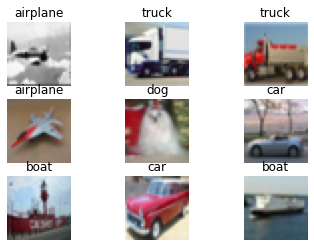

In [109]:
# plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(x_train[i].astype("uint8"))
  plt.title(class_names[np.argmax(y_train[i])])
  plt.axis("off")



# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[np.argmax(labels[i])])
#     plt.axis("off")

In [110]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(x_train)


In [111]:
datagen.flow(x_train, y_train, batch_size=32)[1][0]

array([[[[200.82428  , 193.80405  , 200.       ],
         [200.06584  , 193.67764  , 200.       ],
         [192.90463  , 186.4637   , 193.36092  ],
         ...,
         [154.15082  , 151.91385  , 164.89409  ],
         [111.34331  ,  97.34331  , 109.33158  ],
         [ 56.08892  ,  42.12597  ,  53.137085 ]],

        [[169.36293  , 159.77087  , 168.15895  ],
         [174.54565  , 165.20642  , 173.21527  ],
         [181.88692  , 172.27205  , 179.6733   ],
         ...,
         [148.71529  , 144.96141  , 157.81525  ],
         [104.264465 ,  90.264465 , 102.12633  ],
         [ 59.12271  ,  46.42384  ,  57.81418  ]],

        [[134.20786  , 125.78386  , 137.14787  ],
         [138.50572  , 129.82892  , 140.8137   ],
         [149.8446   , 139.90227  , 149.52953  ],
         ...,
         [145.901    , 139.84161  , 151.72484  ],
         [ 97.18562  ,  83.18562  ,  94.92108  ],
         [ 62.156498 ,  50.721706 ,  62.49127  ]],

        ...,

        [[156.6036   , 127.04388  , 11

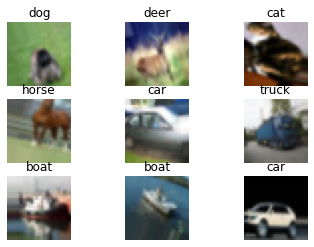

In [112]:
tst = datagen.flow(x_train, y_train, batch_size=32)
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(tst[1][0][i].astype("uint8"))
  plt.title(class_names[np.argmax(tst[1][1][i])])
  plt.axis("off")


In [113]:
pretrained_model = InceptionResNetV2(
    include_top=False, 
    weights='imagenet', 
    input_tensor=None, 
    input_shape=(75, 75, 3),
    pooling='max'    
)

In [114]:
print("Number of layers in the base model: ", len(pretrained_model.layers))

Number of layers in the base model:  781


In [115]:
pretrained_model.trainable = False

In [116]:
pretrained_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_406 (Conv2D)             (None, 37, 37, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_409 (BatchN (None, 37, 37, 32)   96          conv2d_406[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, 37, 37, 32)   0           batch_normalization_409[0][0]    
________________________________________________________________________________

In [117]:
predictions = Dense(9, activation= 'softmax')

inputs = tf.keras.Input(shape=(32, 32, 3))
out = tf.keras.layers.experimental.preprocessing.Resizing(75, 75)(inputs)
out = tf.keras.applications.inception_resnet_v2.preprocess_input(out)
x = tf.keras.layers.BatchNormalization()(out)

x = pretrained_model(x)
x = tf.keras.layers.Dense(512) (x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(256) (x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(64) (x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = predictions(x)
model = tf.keras.Model(inputs, outputs)

In [118]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [119]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resizing_2 (Resizing)        (None, 75, 75, 3)         0         
_________________________________________________________________
tf_op_layer_RealDiv_2 (Tenso [(None, 75, 75, 3)]       0         
_________________________________________________________________
tf_op_layer_Sub_2 (TensorFlo [(None, 75, 75, 3)]       0         
_________________________________________________________________
batch_normalization_612 (Bat (None, 75, 75, 3)         12        
_________________________________________________________________
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_6 (Dense)              (None, 512)              

In [120]:
initial_epochs = 10
BATCH_SIZE = 64

In [121]:
callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    mode='auto',
    restore_best_weights=True
)

In [122]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=initial_epochs,
                    validation_data=(x_val, y_val))

Epoch 1/10
985/985 [==============================] - 277s 281ms/step - loss: 1.9429 - accuracy: 0.4243 - val_loss: 1.7676 - val_accuracy: 0.6019
Epoch 2/10
985/985 [==============================] - 273s 277ms/step - loss: 1.8108 - accuracy: 0.5589 - val_loss: 1.7198 - val_accuracy: 0.6550
Epoch 3/10
985/985 [==============================] - 274s 278ms/step - loss: 1.7833 - accuracy: 0.5865 - val_loss: 1.6993 - val_accuracy: 0.6728
Epoch 4/10
985/985 [==============================] - 274s 278ms/step - loss: 1.7692 - accuracy: 0.6012 - val_loss: 1.6901 - val_accuracy: 0.6811
Epoch 5/10
985/985 [==============================] - 274s 278ms/step - loss: 1.7609 - accuracy: 0.6096 - val_loss: 1.6864 - val_accuracy: 0.6848
Epoch 6/10
985/985 [==============================] - 274s 278ms/step - loss: 1.7515 - accuracy: 0.6189 - val_loss: 1.6743 - val_accuracy: 0.6970
Epoch 7/10
985/985 [==============================] - 274s 278ms/step - loss: 1.7500 - accuracy: 0.6193 - val_loss: 1.6801 -

In [123]:
pretrained_model.trainable = True
tuned_epochs = 100
# fine_tune_at = 200

# for layer in pretrained_model.layers[:fine_tune_at]:
#   layer.trainable =  False

In [124]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [125]:
model.layers[2].trainable = False

In [126]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resizing_2 (Resizing)        (None, 75, 75, 3)         0         
_________________________________________________________________
tf_op_layer_RealDiv_2 (Tenso [(None, 75, 75, 3)]       0         
_________________________________________________________________
tf_op_layer_Sub_2 (TensorFlo [(None, 75, 75, 3)]       0         
_________________________________________________________________
batch_normalization_612 (Bat (None, 75, 75, 3)         12        
_________________________________________________________________
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_6 (Dense)              (None, 512)              

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                    epochs=tuned_epochs,
                    validation_data=(x_val, y_val),
                    initial_epoch=history.epoch[-1],
                    callbacks=[callbacks],                    
                    )

Epoch 10/100
493/493 [==============================] - 230s 466ms/step - loss: 1.7179 - accuracy: 0.6548 - val_loss: 1.5731 - val_accuracy: 0.7992
Epoch 11/100
493/493 [==============================] - 226s 458ms/step - loss: 1.6083 - accuracy: 0.7632 - val_loss: 1.5397 - val_accuracy: 0.8321
Epoch 12/100
493/493 [==============================] - 226s 459ms/step - loss: 1.5804 - accuracy: 0.7903 - val_loss: 1.5235 - val_accuracy: 0.8478
Epoch 13/100
493/493 [==============================] - ETA: 0s - loss: 1.5673 - accuracy: 0.8033

In [ ]:
model.save('model.h5')

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Innopolis/ML Fall 2020/Final/model.h5')

In [ ]:
x_unlabeled = np.load('modified_public/xt_modified.npy')

In [ ]:
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(x_unlabeled[i].astype("uint8"))
  # plt.title(class_names[np.argmax(y_train[i])])
  plt.axis("off")


In [ ]:
y_unlabeled = model.predict(x_unlabeled)

In [ ]:
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(x_unlabeled[i].astype("uint8"))
  plt.title(class_names[np.argmax(y_unlabeled[i])])
  plt.axis("off")


In [ ]:
x_unlabeled.shape

In [ ]:
y_unlabeled.shape

In [ ]:
for i in range(len(y_unlabeled)):
  pos = np.argmax(y_unlabeled[i])
  y_unlabeled[i] = np.zeros(9)
  y_unlabeled[i][pos] = 1

In [ ]:
y_unlabeled.shape

In [ ]:
# y_unlabeled_hot = tf.one_hot(y_unlabeled, 9)

In [ ]:
y_unlabeled_hot.shape

In [ ]:
x_unlabeled_train, x_unlabeled_test, y_unlabeled_train, y_unlabeled_test = train_test_split(x_unlabeled, y_unlabeled, test_size = 0.4)
x_unlabeled_test, x_unlabeled_val, y_unlabeled_test, y_unlabeled_val = train_test_split(x_unlabeled_test, y_unlabeled_test, test_size = 0.5)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(x_unlabeled)


In [ ]:
tst = datagen.flow(x_unlabeled_train, y_unlabeled_train, batch_size=32)
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(tst[1][0][i].astype("uint8"))
  plt.title(class_names[np.argmax(tst[1][1][i])])
  plt.axis("off")
